## Exploration with Data and Visuals
#### Gavin Qu 11-09-2025

### 1. API Config

In [28]:
from opensky_api import OpenSkyApi
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

api = OpenSkyApi()
s = api.get_states()

records = []
for state in s.states:
    # Only include aircraft with valid lat/lon
    if state.longitude is not None and state.latitude is not None:
        records.append({
            "icao24": state.icao24,
            "callsign": state.callsign.strip() if state.callsign else None,
            "origin_country": state.origin_country,
            "time_position": state.time_position,
            "last_contact": state.last_contact,
            "lon": state.longitude,
            "lat": state.latitude,
            "baroaltitude": state.baro_altitude,
            "on_ground": state.on_ground,
            "velocity": state.velocity,
            "heading": state.true_track,
            "vertical_rate": state.vertical_rate
        })

df = pd.DataFrame(records).reset_index(drop=True)

# Build geometry 
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326"  # coordinate reference system used by GPS
)
print(f"Successfully fetched {len(gdf)} flight states with valid positions.")
display(gdf.head())
print(gdf.dtypes)

Successfully fetched 5525 flight states with valid positions.


,icao24,callsign,origin_country,time_position,last_contact,lon,lat,baroaltitude,on_ground,velocity,heading,vertical_rate,geometry
0,aa9321,UAL915,United States,1762837926,1762837926,-4.5848,49.5077,11887.20,False,261.40,91.24,0.00,POINT (-4.5848 49.5077)
1,801642,AXB242,India,1762837926,1762837927,100.5439,14.1932,4038.60,False,165.26,118.24,-4.23,POINT (100.5439 14.1932)
2,a3b87f,DAL1584,United States,1762837907,1762837907,-118.4250,33.9480,NaN,True,7.72,180.00,NaN,POINT (-118.425 33.948)
3,801643,AXB1624,India,1762837902,1762837902,76.8508,25.7707,10668.00,False,226.72,176.75,0.00,POINT (76.8508 25.7707)
4,8a02ff,None,Indonesia,1762837807,1762837833,102.8448,-1.7566,9151.62,False,233.15,321.36,0.00,POINT (102.8448 -1.7566)


icao24              object
callsign            object
origin_country      object
time_position        int64
last_contact         int64
lon                float64
lat                float64
baroaltitude       float64
on_ground             bool
velocity           float64
heading            float64
vertical_rate      float64
geometry          geometry
dtype: object


### 2. Visuals
#### 2.1 Map of Live Flight

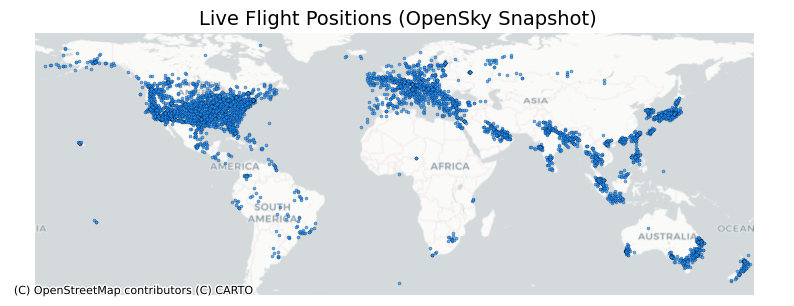

In [29]:
import matplotlib.pyplot as plt
import contextily as cx

fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, markersize=5, alpha=0.7, color="dodgerblue", edgecolor="k", linewidth=0.2)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)
ax.set_title("Live Flight Positions (OpenSky Snapshot)", fontsize=14)
ax.set_axis_off()
plt.show()

#### 2.2 Altitude Distribution (vertical structure)
bimodal structure: low-altitude domestic flights or climbs/descents and a thick band around 30–40 kft for cruise levels.

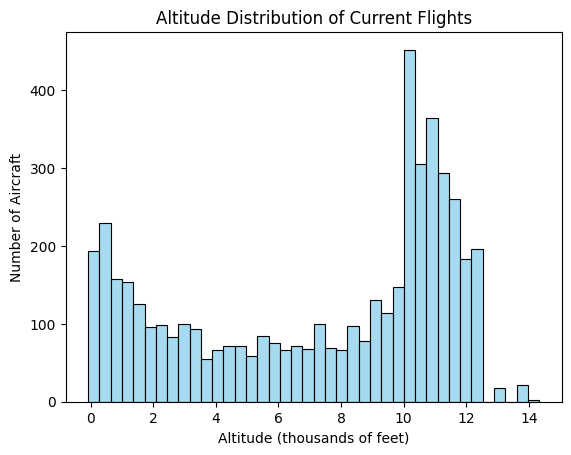

In [30]:
import seaborn as sns

sns.histplot(gdf["baroaltitude"].dropna() / 1000, bins=40, color="skyblue")
plt.xlabel("Altitude (thousands of feet)")
plt.ylabel("Number of Aircraft")
plt.title("Altitude Distribution of Current Flights")
plt.show()

#### 2.3 Velocity vs. Altitude Scatter

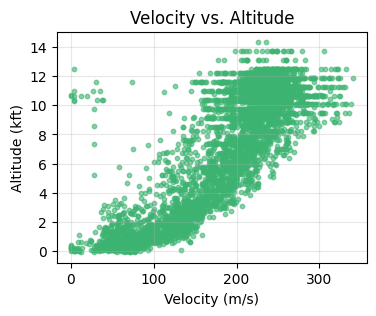

In [32]:
plt.figure(figsize=(4,3))
plt.scatter(gdf["velocity"], gdf["baroaltitude"]/1000, s=10, alpha=0.6, color="mediumseagreen")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Altitude (kft)")
plt.title("Velocity vs. Altitude")
plt.grid(True, alpha=0.3)
plt.show()

#### 2.4 Flight Density Heatmap 

In [36]:
import geopandas as gpd
import zipfile
import requests
from io import BytesIO

# Download Natural Earth shapefile (countries, 1:110m resolution)
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
r = requests.get(url)
with zipfile.ZipFile(BytesIO(r.content)) as z:
    z.extractall("data/natural_earth")  # stores shapefiles locally

# Load the shapefile
world = gpd.read_file("data/natural_earth/ne_110m_admin_0_countries.shp")

# Filter for the U.S.
usa = world[world["ADMIN"] == "United States of America"]
print(usa.head())

        featurecla  scalerank  LABELRANK                SOVEREIGNT SOV_A3  \
4  Admin-0 country          1          2  United States of America    US1   

   ADM0_DIF  LEVEL     TYPE TLC                     ADMIN  ... FCLASS_TR  \
4         1      2  Country   1  United States of America  ...      None   

   FCLASS_ID FCLASS_PL FCLASS_GR  FCLASS_IT FCLASS_NL FCLASS_SE  FCLASS_BD  \
4       None      None      None       None      None      None       None   

  FCLASS_UA                                           geometry  
4      None  MULTIPOLYGON (((-122.84 49, -120 49, -117.0312...  

[1 rows x 169 columns]


Flights within U.S. borders: 2173


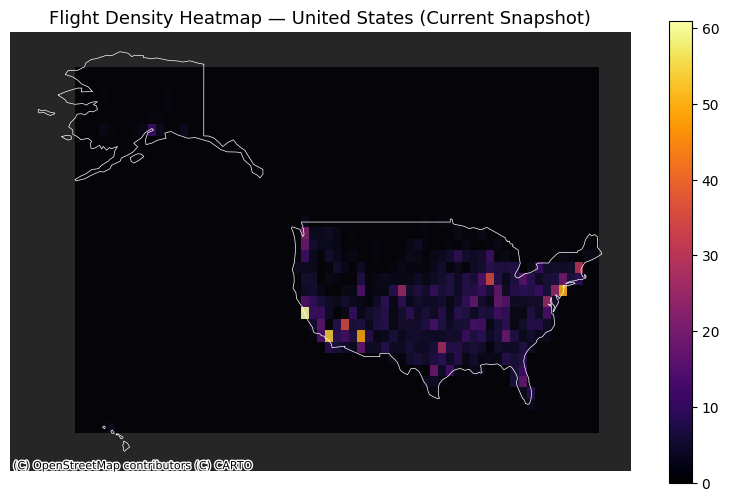

In [39]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import contextily as cx
import matplotlib.pyplot as plt

# gdf contains columns: lat, lon, geometry (Point), crs="EPSG:4326"
# --- clip to the U.S. boundary ---
gdf_us = gpd.clip(gdf, usa)
print(f"Flights within U.S. borders: {len(gdf_us)}")

# --- define grid bounds & resolution ---
xmin, ymin, xmax, ymax = gdf_us.total_bounds
dx = dy = 1.5  # degrees — smaller = more detail
cols = np.arange(xmin, xmax + dx, dx)
rows = np.arange(ymin, ymax + dy, dy)

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x, y), (x+dx, y), (x+dx, y+dy), (x, y+dy)]))

grid = gpd.GeoDataFrame({"geometry": polygons}, crs=gdf_us.crs)

# --- spatial join: count how many flights fall in each grid cell ---
joined = gpd.sjoin(gdf_us, grid, predicate="within")
counts = joined.groupby("index_right").size()
grid["count"] = counts
grid["count"].fillna(0, inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))
grid.plot(
    column="count",
    cmap="inferno",
    alpha=0.85,
    linewidth=0,
    legend=True,
    ax=ax
)
usa.boundary.plot(ax=ax, color="white", linewidth=0.5)
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter)
ax.set_title("Flight Density Heatmap — United States (Current Snapshot)", fontsize=13)
ax.set_axis_off()
plt.show()

### 3. Interactive Deck.gl Map
pydeck expects plain lat/lon columns, not shapely polygons. So we’ll extract the centroid of each grid cell 

In [40]:
import pydeck as pdk

# Compute centroids for plotting
grid["lon"] = grid.geometry.centroid.x
grid["lat"] = grid.geometry.centroid.y

# Normalize counts for visual scaling
grid["count_norm"] = grid["count"] / grid["count"].max()

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_2377/3924334916.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["lon"] = grid.geometry.centroid.x
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_2377/3924334916.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["lat"] = grid.geometry.centroid.y


In [41]:
# build the columnlayer, 3D towers of density of flight
# Define the layer
layer = pdk.Layer(
    "ColumnLayer",
    data=grid,
    get_position=["lon", "lat"],
    get_elevation="count_norm * 50000",   # tweak this scaling factor
    elevation_scale=1,
    radius=50000,                         # radius of each column (in meters)
    get_fill_color="[255 * count_norm, 140, 0, 180]",  # orange gradient
    pickable=True,
    auto_highlight=True,
)

In [44]:
# US centered camera view
view_state = pdk.ViewState(
    longitude=-98,  # roughly center of U.S.
    latitude=39,
    zoom=3.2,
    pitch=40,
)

deck = pdk.Deck(
    layers=[layer],
    initial_view_state=view_state,
    map_style="mapbox://styles/mapbox/dark-v10",
    tooltip={"text": "Flights: {count}"}
)

deck.to_html("flight_density_us.html", open_browser=True)